# Imports

In [1]:
# HIDE
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as t_optim
#import skorch
import pickle
from IPython import display
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
#from cont_metrics.density_estimation.pytorch_kde import kde
#from cont_metrics.hgr import hgr_cond
#from cont_metrics.hgr import hgr
import aif360 as aif

from fairness.helpers import load_ICU_data
from fairness.helpers import plot_distributions
from fairness.helpers import *

#from fairlearn.postprocessing import ThresholdOptimizer
#from fairlearn.postprocessing import plot_threshold_optimizer

from fairness.avd_helpers import *

#from aif360.algorithms.postprocessing import *
import aif360
from aif360.datasets import CompasDataset
from aif360.algorithms.inprocessing import AdversarialDebiasing
#from comet_ml import Experiment
import tensorflow.compat.v1 as tf
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import LFR

from aif360.sklearn.preprocessing import LearnedFairRepresentations as LFR_sk
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

import time

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="colorblind", color_codes=True, context="talk")
sns.set_theme()

tf.disable_eager_execution()

%matplotlib inline

pip install 'aif360[LawSchoolGPA]'
2023-02-03 14:01:14.317901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[FairAdapt]'


# Load Data

In [4]:
# load ICU data set
X, y, Z = load_ICU_data('../../data/adult/adult.data', just_sex=True, just_race=False)

n_features = X.shape[1]
n_sensitive = Z.shape[1]

(X_train, X_test, y_train, y_test, Z_train, Z_test) = split_scale_pipe(X, y, Z, stratify=y)

# Biased Model

In [5]:
train_data = BinaryLabelDataset(df=X_train.assign(target = y_train, sex=Z_train), label_names=['target'], protected_attribute_names=['sex'])
test_data = BinaryLabelDataset(df=X_test.assign(target=y_test, sex=Z_test), label_names=['target'], protected_attribute_names=['sex'])


tf.reset_default_graph()
sess = tf.Session()


privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

biased_model = AdversarialDebiasing(unprivileged_groups=unprivileged_groups,
                 privileged_groups=privileged_groups,
                 scope_name='classifier',
                 debias=False,
                 sess=sess,
                 seed=111).fit(train_data)

preds = biased_model.predict(test_data).labels
acc = metrics.accuracy_score(y_test, preds) * 100
b_acc = metrics.balanced_accuracy_score(y_test, preds) * 100
prule = p_rule(preds, Z_test)

2023-02-03 14:01:21.984010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2023-02-03 14:01:22.182113: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 0.745683
epoch 1; iter: 0; batch classifier loss: 0.340462
epoch 2; iter: 0; batch classifier loss: 0.362507
epoch 3; iter: 0; batch classifier loss: 0.399303
epoch 4; iter: 0; batch classifier loss: 0.286108
epoch 5; iter: 0; batch classifier loss: 0.274688
epoch 6; iter: 0; batch classifier loss: 0.227595
epoch 7; iter: 0; batch classifier loss: 0.287854
epoch 8; iter: 0; batch classifier loss: 0.342393
epoch 9; iter: 0; batch classifier loss: 0.285075
epoch 10; iter: 0; batch classifier loss: 0.322549
epoch 11; iter: 0; batch classifier loss: 0.356707
epoch 12; iter: 0; batch classifier loss: 0.286051
epoch 13; iter: 0; batch classifier loss: 0.260908
epoch 14; iter: 0; batch classifier loss: 0.233734
epoch 15; iter: 0; batch classifier loss: 0.298613
epoch 16; iter: 0; batch classifier loss: 0.285890
epoch 17; iter: 0; batch classifier loss: 0.245702
epoch 18; iter: 0; batch classifier loss: 0.243477
epoch 19; iter: 0; batch classifier loss:

In [6]:
print('Biased model:')
print(f'accuracy: {acc:.2f}%')
print(f'balanced accuracy: {b_acc:.2f}%')
print(f'p-rule: {prule:.2f}%')

Biased model:
accuracy: 85.18%
balanced accuracy: 77.94%
p-rule: 31.45%


In [7]:
test_results = pd.DataFrame(Z_test).assign(biased_pred = preds)
test_results = test_results.assign(biased_scores = biased_model.predict(test_data).scores)
test_results.head()

sex  biased_pred  biased_scores
24652    1          0.0       0.048509
26303    1          0.0       0.490995
21531    0          0.0       0.173168
294      0          0.0       0.001204
28849    0          0.0       0.177355

# Adversarial

In [8]:
adv_accs = []
adv_b_accs = []
adv_prules = []
adv_numch = []
adv_changed = []

In [33]:
for i in range(10):

    torch.manual_seed(i*100)
    train_data = BinaryLabelDataset(df=X_train.assign(target = y_train, sex=Z_train), label_names=['target'], protected_attribute_names=['sex'])
    test_data = BinaryLabelDataset(df=X_test.assign(target=y_test, sex=Z_test), label_names=['target'], protected_attribute_names=['sex'])


    tf.reset_default_graph()
    sess_adv = tf.Session()


    privileged_groups = [{'sex': 1}]
    unprivileged_groups = [{'sex': 0}]

    adv_model = AdversarialDebiasing(unprivileged_groups=unprivileged_groups,
                     privileged_groups=privileged_groups,
                     scope_name='classifier',
                     debias=True,
                     sess=sess_adv,
                     adversary_loss_weight=0.3).fit(train_data)

    adv_preds = adv_model.predict(test_data).labels
    adv_scores = adv_model.predict(test_data).scores
    acc = metrics.accuracy_score(y_test, adv_preds) * 100
    b_acc = metrics.balanced_accuracy_score(y_test, adv_preds) * 100
    prule = p_rule(adv_preds, Z_test)

    t = test_results.assign(pred = adv_preds)
    t = t.assign(change = t.pred - t.biased_pred)
    changed = t[t.change!=0]

    num_changed = len(changed)
    adv_numch.append(num_changed)
    adv_changed.append(changed)

    adv_accs.append(acc)
    adv_b_accs.append(b_acc)
    adv_prules.append(prule)

    print(f'run {i}')
    print(f'accuracy = {acc:.2f}%')
    print(f'balanced accuracy = {b_acc:.2f}%')
    print(f'p-rule = {prule:.2f}%')
    print(num_changed)

epoch 0; iter: 0; batch classifier loss: 0.773550; batch adversarial loss: 0.787580
epoch 1; iter: 0; batch classifier loss: 0.452844; batch adversarial loss: 0.753145
epoch 2; iter: 0; batch classifier loss: 0.748671; batch adversarial loss: 0.653451
epoch 3; iter: 0; batch classifier loss: 0.343408; batch adversarial loss: 0.663878
epoch 4; iter: 0; batch classifier loss: 0.257966; batch adversarial loss: 0.603460
epoch 5; iter: 0; batch classifier loss: 0.296242; batch adversarial loss: 0.676059
epoch 6; iter: 0; batch classifier loss: 0.317515; batch adversarial loss: 0.659192
epoch 7; iter: 0; batch classifier loss: 0.300021; batch adversarial loss: 0.687243
epoch 8; iter: 0; batch classifier loss: 0.253564; batch adversarial loss: 0.628154
epoch 9; iter: 0; batch classifier loss: 0.310745; batch adversarial loss: 0.608015
epoch 10; iter: 0; batch classifier loss: 0.331480; batch adversarial loss: 0.597208
epoch 11; iter: 0; batch classifier loss: 0.264621; batch adversarial loss:

In [11]:
print(f'accuracy = {acc:.2f}%')
print(f'balanced accuracy = {b_acc:.2f}%')
print(f'p-rule = {prule:.2f}%')

accuracy = 84.18%
balanced accuracy = 72.70%
p-rule = 73.19%


In [34]:
prs = np.array(adv_prules)
prs[prs>80]
pd.DataFrame(np.array([a/len(test_results)*100 for a in adv_numch])[prs>80]).describe()

0
count  10.000000
mean   10.728994
std     0.946906
min     9.226136
25%    10.258774
50%    10.836560
75%    11.070133
max    12.422398

In [39]:
np.array(adv_numch)[prs>80]

array([1786, 1752, 1501, 1774, 1726, 1545, 1806, 1650, 2021, 1894])

In [10]:
test_results = test_results.assign(adv_pred = adv_preds)
test_results = test_results.assign(adv_score = adv_scores)

In [12]:
test_results.head()

sex  biased_pred  biased_scores  adv_pred  adv_score
24652    1          0.0       0.048509       0.0   0.024298
26303    1          0.0       0.490995       0.0   0.257750
21531    0          0.0       0.173168       0.0   0.330302
294      0          0.0       0.001204       0.0   0.004775
28849    0          0.0       0.177355       0.0   0.294263

# LFR

In [40]:
lfr_accs = []
lfr_b_accs = []
lfr_prules = []
lfr_numch = []
lfr_changed = []

In [48]:
for i in range(10):

    torch.manual_seed(i*100)

    lfr = LFR_sk(prot_attr='sex', n_prototypes=5, reconstruct_weight=0.01,
                     target_weight=10., fairness_weight=15., tol=1e-4, max_iter=300,
                     verbose=0).fit(X_train.assign(sex=Z_train).set_index('sex'), y_train)

    X_train_transf = lfr.transform(X_train)

    #lfr_model = Classifier_old(X_train.shape[1])
    X_test_transf = lfr.transform(X_test)

    new_train = BinaryLabelDataset(df=X_train_transf.assign(target = y_train, sex=Z_train), label_names=['target'], protected_attribute_names=['sex'])
    new_test_data = BinaryLabelDataset(df=X_test_transf.assign(target = y_test, sex=Z_test), label_names=['target'], protected_attribute_names=['sex'])

    train_data = PandasDataSet(X_train_transf, y_train, Z_train)
    test_data = PandasDataSet(X_test_transf, y_test, Z_test)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)

    start = time.time()

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)

    clf = Classifier_old(n_features=X_train.shape[1])
    clf_criterion = nn.BCELoss()
    clf_optimizer = optim.Adam(clf.parameters())

    N_CLF_EPOCHS = 30

    # pretrain classifier

    clf, losses = fit_clf(clf, clf_optimizer, clf_criterion, train_loader, num_epochs=N_CLF_EPOCHS)

    with torch.no_grad():
        pre_clf_test = clf(test_data.tensors[0])

    y_pre_clf = pd.Series(pre_clf_test.data.numpy().ravel(),
                         index=y_test.index)

    acc = metrics.accuracy_score(y_test, y_pre_clf > 0.5) * 100
    b_acc = metrics.balanced_accuracy_score(y_test, y_pre_clf > 0.5) * 100
    prule = p_rule(y_pre_clf, Z_test.sex)

    lfr_accs.append(acc)
    lfr_b_accs.append(b_acc)
    lfr_prules.append(prule)

    t = test_results.assign(lfr_pred = (y_pre_clf>0.5)*1)
    t = t.assign(lfr_change = t.lfr_pred - t.biased_pred)
    changed = t[t.lfr_change!=0]

    num_changed = len(changed)
    lfr_changed.append(changed)
    lfr_numch.append(num_changed)

    print(f'run {i}')
    print(f'accuracy = {acc:.2f}%')
    print(f'balanced accuracy = {b_acc:.2f}%')
    print(f'p-rule = {prule:.2f}%')
    print(f'num changed = {num_changed}')

run 0
accuracy = 81.54%
balanced accuracy = 71.38%
p-rule = 97.20%
num changed = 2014
run 1
accuracy = 82.65%
balanced accuracy = 72.48%
p-rule = 61.55%
num changed = 1598
run 2
accuracy = 82.55%
balanced accuracy = 71.02%
p-rule = 95.79%
num changed = 1880
run 3
accuracy = 82.46%
balanced accuracy = 70.77%
p-rule = 97.80%
num changed = 1900
run 4
accuracy = 82.46%
balanced accuracy = 71.60%
p-rule = 96.13%
num changed = 1929
run 5
accuracy = 82.37%
balanced accuracy = 73.87%
p-rule = 65.65%
num changed = 1703
run 6
accuracy = 82.74%
balanced accuracy = 71.37%
p-rule = 67.62%
num changed = 1719
run 7
accuracy = 82.91%
balanced accuracy = 71.29%
p-rule = 76.46%
num changed = 1713
run 8
accuracy = 82.09%
balanced accuracy = 70.25%
p-rule = 91.80%
num changed = 1956
run 9
accuracy = 82.54%
balanced accuracy = 72.30%
p-rule = 78.15%
num changed = 1720


In [57]:
prs = np.array(lfr_prules)
len(prs[prs>80])

12

In [61]:
df_lfr = pd.DataFrame({
    'run': range(len(lfr_accs)),
    'Accuracy': lfr_accs,
    'Balanced Accuracy': lfr_b_accs,
    'P%-rule': lfr_prules,
    '% of preds changed': [a/len(test_results)*100 for a in lfr_numch],
    'num preds changed': lfr_numch
}).loc[prs>80]
df_lfr.describe()

run   Accuracy  Balanced Accuracy    P%-rule  % of preds changed  \
count  12.00000  12.000000          12.000000  12.000000           12.000000   
mean    8.50000  82.249472          71.318014  93.908043           11.698117   
std     5.33428   0.319582           0.934402   4.111203            0.418316   
min     0.00000  81.541582          70.203972  85.113019           10.805827   
25%     5.50000  82.099391          70.728426  91.415443           11.511156   
50%     8.50000  82.349868          71.200412  95.120896           11.746266   
75%    12.25000  82.463581          71.641213  97.266314           11.999816   
max    18.00000  82.635688          73.021087  98.753941           12.379372   

       num preds changed  
count          12.000000  
mean         1903.166667  
std            68.055904  
min          1758.000000  
25%          1872.750000  
50%          1911.000000  
75%          1952.250000  
max          2014.000000

In [14]:
test_results = test_results.assign(lfr_pred = y_pre_clf)

## Reject Option Classifier

In [134]:
test_data = BinaryLabelDataset(df=X_test.assign(target=y_test, sex=Z_test), label_names=['target'], protected_attribute_names=['sex'])

scores = biased_model.predict(test_data).scores.flatten()
labels = biased_model.predict(test_data).labels.flatten()
preds = RejectOptionClassifier(0.86).predict(scores, Z_test.values.flatten())

print(f'accuracy: {metrics.accuracy_score(y_test, (scores>0.5)*1) * 100:.2f}%')
print(f'balanced accuracy: {metrics.balanced_accuracy_score(y_test, (scores>0.5)*1) * 100:.2f}%')
print(f'p-rule: {p_rule((scores>0.5)*1, Z_test.values.flatten()):.2f}%')

print('----------------------')
print('Debiased:')

print(f'accuracy: {metrics.accuracy_score(y_test, preds) * 100:.2f}%')
print(f'balanced accuracy: {metrics.balanced_accuracy_score(y_test, preds) * 100:.2f}%')
print(f'p-rule: {p_rule(preds, Z_test.values.flatten()):.2f}%')

accuracy: 85.18%
balanced accuracy: 77.94%
p-rule: 31.45%
----------------------
Debiased:
accuracy: 82.30%
balanced accuracy: 65.22%
p-rule: 94.10%


In [135]:
test_results = test_results.assign(roc_pred = preds)
t = test_results.assign(change = test_results.roc_pred - test_results.biased_pred)
roc_numch = len(t[t.change!=0])

## Adversarial Equal Odds

In [64]:
from fairlearn_int.adversarial import AdversarialFairnessClassifier as AFC
from fairlearn_int.metrics import equalized_odds_difference, equalized_odds_ratio

In [65]:
adv_eo_accs = []
adv_eo_b_accs = []
adv_eo_prules = []
adv_eo_eqd = []
adv_eo_eqr = []
adv_eo_numch = []
adv_eo_changed = []

In [98]:
for i in range(10):
    torch.manual_seed(i*1000)

    afc_ = AFC(backend='torch',
       predictor_model=[200, nn.ReLU()],#, 32, nn.ReLU(), 32, nn.ReLU()],
       adversary_model=avh.Adversary_old(n_input = 2, n_hidden=128),#[32, nn.ReLU(), 32, nn.ReLU(), 32, nn.ReLU()],
       constraints='equalized_odds',
       epochs=40,
       alpha=81.5, random_state = i*1000, shuffle=True)

    afc = afc_.fit(X_train, y_train, sensitive_features=Z_train)

    preds = afc.predict(X_test)

    eq_odds_ratio = equalized_odds_ratio(y_true=y_test, y_pred=preds, 
                                                         sensitive_features=Z_test)
    eq_odds_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, 
                                                         sensitive_features=Z_test)
    acc = metrics.accuracy_score(y_test, preds) * 100
    b_acc = metrics.balanced_accuracy_score(y_test, preds) * 100
    prule = p_rule(preds, Z_test.sex.values)

    adv_eo_accs.append(acc)
    adv_eo_b_accs.append(b_acc)
    adv_eo_prules.append(prule)
    adv_eo_eqd.append(eq_odds_diff)
    adv_eo_eqr.append(eq_odds_ratio)

    t = test_results.assign(pred = preds.values)
    t = t.assign(change = t.pred - t.biased_pred)
    changed = t[t.change!=0]

    num_changed = len(changed)
    adv_eo_numch.append(num_changed)
    adv_eo_changed.append(changed)


    print('Adversarial (optimizing equalized odds):')
    print(f'accuracy = {acc:.2f}%')
    print(f'balanced accuracy = {b_acc:.2f}%')
    print(f'p-rule = {prule:.2f}%')
    print(f'Equalized Odds ratio = {eq_odds_ratio:.2f}')
    print(f'Equalized Odds difference = {eq_odds_diff:.2f}')
    print(num_changed)
    print()

    """Adversarial (optimizing equalized odds):
    accuracy = 83.39%
    balanced accuracy = 74.43%
    p-rule = 55.55%
    Equalized Odds ratio = 0.74
    Equalized Odds difference = 0.08
    10777


    Adversarial (optimizing equalized odds):
    accuracy = 84.39%
    balanced accuracy = 73.00%
    p-rule = 52.24%
    Equalized Odds ratio = 0.64
    Equalized Odds difference = 0.11
    1294

    accuracy = 84.48%
    balanced accuracy = 73.84%
    p-rule = 48.26%
    Equalized Odds ratio = 0.53
    Equalized Odds difference = 0.09
    1118
    """

Adversarial (optimizing equalized odds):
accuracy = 84.93%
balanced accuracy = 77.65%
p-rule = 36.64%
Equalized Odds ratio = 0.33
Equalized Odds difference = 0.08
690

Adversarial (optimizing equalized odds):
accuracy = 84.87%
balanced accuracy = 75.92%
p-rule = 32.00%
Equalized Odds ratio = 0.25
Equalized Odds difference = 0.07
805

Adversarial (optimizing equalized odds):
accuracy = 78.34%
balanced accuracy = 76.22%
p-rule = 92.73%
Equalized Odds ratio = 0.69
Equalized Odds difference = 0.12
2321

Adversarial (optimizing equalized odds):
accuracy = 84.25%
balanced accuracy = 75.34%
p-rule = 44.56%
Equalized Odds ratio = 0.52
Equalized Odds difference = 0.04
896

Adversarial (optimizing equalized odds):
accuracy = 83.93%
balanced accuracy = 75.26%
p-rule = 66.74%
Equalized Odds ratio = 0.73
Equalized Odds difference = 0.21
1186

Adversarial (optimizing equalized odds):
accuracy = 84.93%
balanced accuracy = 77.34%
p-rule = 32.29%
Equalized Odds ratio = 0.25
Equalized Odds difference = 

RuntimeError: all elements of input should be between 0 and 1

In [113]:
eqrs = np.array(adv_eo_eqr[-20:])
pd.DataFrame([a/len(test_results)*100 for a in adv_eo_numch[-20:]]).loc[eqrs>0.6].describe()

0
count   8.000000
mean    8.975659
std     3.318794
min     6.392526
25%     7.065585
50%     7.621858
75%     9.531932
max    14.266396

In [114]:
test_results = test_results.assign(adveq_pred = preds.values)

# Equal Odds

In [115]:
from fairlearn_int.postprocessing import ThresholdOptimizer as EQ

In [116]:
train_data = BinaryLabelDataset(df=X_train.assign(target = y_train, sex=Z_train), label_names=['target'], protected_attribute_names=['sex'])
test_data = BinaryLabelDataset(df=X_test.assign(target=y_test, sex=Z_test), label_names=['target'], protected_attribute_names=['sex'])

In [117]:
eo_accs = []
eo_b_accs = []
eo_prules = []
eo_rs = []
eo_ds = []
eo_numch = []
eo_changed = []

In [123]:

train_data = BinaryLabelDataset(df=X_train.assign(target = y_train, sex=Z_train), label_names=['target'], protected_attribute_names=['sex'])
test_data = BinaryLabelDataset(df=X_test.assign(target=y_test, sex=Z_test), label_names=['target'], protected_attribute_names=['sex'])


m = EQ(estimator=biased_model, predict_method='predict', 
       prefit=True, constraints='equalized_odds').fit(X=torch.Tensor(X_train.assign(sex=Z_train).set_index('sex').to_numpy()), 
                                                             y=torch.Tensor(y_train.to_numpy()),
                                                             Z=torch.Tensor(Z_train.to_numpy()), 
                                                             sensitive_features=torch.Tensor(Z_train.to_numpy()),
                                                                         bld=train_data)

preds = m.predict(X=X_test, y=y_test, Z=Z_test, sensitive_features=Z_test,
                  bld=BinaryLabelDataset(df=X_test.join(y_test).join(Z_test), label_names=['target'], protected_attribute_names=['sex'])
                 )

acc = metrics.accuracy_score(y_test, (preds>0.5).astype(int)) * 100
b_acc = metrics.balanced_accuracy_score(y_test, (preds>0.5).astype(int)) * 100
prule = p_rule(preds, Z_test.sex)

eq_odds_ratio = equalized_odds_ratio(y_true=y_test, y_pred=preds, 
                                                     sensitive_features=Z_test)
eq_odds_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, 
                                                     sensitive_features=Z_test)

eo_numch.append(num_changed)
eo_changed.append(changed)
eo_accs.append(acc)
eo_b_accs.append(b_acc)
eo_prules.append(prule)
eo_rs.append(eq_odds_ratio)
eo_ds.append(eq_odds_diff)

print(f'accuracy = {acc:.2f}%')
print(f'balanced accuracy = {b_acc:.2f}%')
print(f'p-rule = {prule:2f}%')

print(f'Equalized Odds ratio = {eq_odds_ratio:.2f}')
print(f'Equalized Odds difference = {eq_odds_diff:.2f}')

accuracy = 83.98%
balanced accuracy = 74.10%
p-rule = 51.646725%
Equalized Odds ratio = 0.73
Equalized Odds difference = 0.03


In [28]:
test_results = test_results.assign(
    eq_pred = preds
)

# Plots (runs)

In [155]:
adv_eo = pd.DataFrame({'adv_eo': [a/len(test_results)*100 for a in adv_eo_numch[-20:]]}).loc[eqrs>0.6].reset_index().drop(columns=['index'])
eo = pd.DataFrame({'eo':[e/len(test_results)*100 for e in eo_numch]}).loc[0:8]
roc = pd.DataFrame({'roc':roc_numch/len(test_results)*100}, index=range(8))#.drop()
lfr = df_lfr.reset_index()[['% of preds changed']].loc[0:8].rename({'% of preds changed': 'lfr'}, axis=1)
adv = pd.DataFrame({'adv': np.array([a/len(test_results)*100 for a in adv_numch])[prs>80]}).loc[0:8]

In [160]:
pd.concat([
    adv_eo, eo, roc, lfr, adv
], axis=1).loc[0:7].to_csv('../../results/runs/adult.csv')

# Comparisons

In [29]:
test_results = test_results.assign(lfr_pred = (test_results.lfr_pred>0.5).astype(int))

In [30]:
test_results = test_results.assign(target = y_test)
test_results.head()

sex  biased_pred  adv_pred  lfr_pred  roc_pred  adveq_pred  eq_pred  \
24652    1          0.0       0.0         0       0.0           0        0   
26303    1          0.0       0.0         0       0.0           0        0   
21531    0          0.0       0.0         1       0.0           1        0   
294      0          0.0       0.0         0       0.0           0        0   
28849    0          0.0       0.0         1       0.0           0        0   

       target  
24652       0  
26303       0  
21531       0  
294         0  
28849       0

In [31]:
test_results = test_results.rename({'biased_pred':'biased_label'}, axis=1)

In [32]:
metrics_ = get_metrics([test_results[['target', 'adv_pred', 'biased_label', 'sex']].rename({'adv_pred':'fair_label'}, axis=1),
                        test_results[['target', 'lfr_pred', 'biased_label', 'sex']].assign(fair_label = lambda x: (x.lfr_pred >0.5).astype(int)),
                        test_results[['target', 'roc_pred', 'biased_label', 'sex']].rename({'roc_pred':'fair_label'}, axis=1),
                        test_results[['target', 'adveq_pred', 'biased_label', 'sex']].rename({'adveq_pred':'fair_label'}, axis=1),
                        test_results[['target', 'eq_pred', 'biased_label', 'sex']].rename({'eq_pred':'fair_label'}, axis=1)
                       ],
                       ['adversarial', 'lfr', 'roc', 'Adversarial (equal odds)', 'Equal Odds'], 'sex')
metrics_

approach  accuracy  balanced accuracy  class 0 accuracy  \
0               adversarial  0.832135           0.701632          0.914307   
1                       lfr  0.818551           0.705830          0.880437   
2                       roc  0.823038           0.652195          0.929299   
3  Adversarial (equal odds)  0.833917           0.744334          0.899315   
4                Equal Odds  0.839818           0.740995          0.903942   
5                    biased  0.851804           0.779362          0.929299   

   class 1 accuracy   p% rules  eo_ratios  eo_diffs  
0          0.791276  97.488759   0.526806  0.355291  
1          0.787778  97.491806   0.551504  0.329569  
2          0.770201  94.103035   0.464120  0.300282  
3          0.801399  55.549299   0.735388  0.075548  
4          0.807933  51.646725   0.727775  0.033442  
5          0.813271  31.450470   0.233066  0.088344

In [33]:
test_results = test_results.assign(biased_pred = test_results.biased_label)

In [34]:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
                    'martial_status', 'occupation', 'relationship', 'race', 'sex',
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
input_data = (pd.read_csv('../../data/adult/adult.data', names=column_names,
                          na_values="?", sep=r'\s*,\s*', engine='python')
             )

In [35]:
comp_df = input_data.loc[X_test.index].assign(
    biased_pred = test_results.biased_pred,
    adv_pred = test_results.adv_pred,
    lfr_pred = (test_results.lfr_pred>0.5).astype(int),
    eq_pred = test_results.eq_pred,
    roc_pred = test_results.roc_pred,
    adveq_pred = test_results.adveq_pred,
    target = test_results.target
)

In [36]:
comp_df = comp_df.assign(biased_pred = (comp_df.biased_pred>0.5).astype(int))

In [37]:
comp_df = comp_df.assign(
    adv_change = comp_df.adv_pred - comp_df.biased_pred,
    lfr_change = comp_df.lfr_pred - comp_df.biased_pred,
    roc_change = comp_df.roc_pred - comp_df.biased_pred,
    eq_change = comp_df.eq_pred - comp_df.biased_pred,
    adveq_change = comp_df.adveq_pred - comp_df.biased_pred
)

In [38]:
comp_df.head()

age workclass  fnlwgt     education  education_num      martial_status  \
24652   27   Private   50132  Some-college             10            Divorced   
26303   37   Private  259846     Assoc-voc             11  Married-civ-spouse   
21531   32   Private  199655  Some-college             10  Married-civ-spouse   
294     27   Private  248402     Bachelors             13       Never-married   
28849   67       NaN   39100       HS-grad              9  Married-civ-spouse   

         occupation   relationship   race     sex  ...  adv_pred  lfr_pred  \
24652         Sales  Not-in-family  White    Male  ...       0.0         0   
26303  Adm-clerical        Husband  White    Male  ...       0.0         0   
21531  Adm-clerical           Wife  Other  Female  ...       0.0         1   
294    Tech-support      Unmarried  Black  Female  ...       0.0         0   
28849           NaN           Wife  White  Female  ...       0.0         1   

       eq_pred roc_pred  adveq_pred  adv_change  lfr_change  roc_change  \
24652        0      0.0           0         0.0           0         0.0   
26303        0      0.0           0         0.0           0         0.0   
21531        0      0.0           1         0.0           1         0.0   
294          0      0.0           0         0.0           0         0.0   
28849        0      0.0           0         0.0           1         0.0   

       eq_change  adveq_change  
24652          0             0  
26303          0             0  
21531          0             1  
294            0             0  
28849          0             0  

[5 rows x 26 columns]

## Numbers of people changed

### paper tables

In [39]:
t = test_results
num_women = len(t[t.sex==0])
num_men = len(t[t.sex==1])

#### Adversarial

In [40]:
t = t.drop(columns=['biased_label']).assign(
    adv_change = t.adv_pred - t.biased_pred,
    lfr_change = t.lfr_pred - t.biased_pred,
    roc_change = t.roc_pred - t.biased_pred,
    eq_change = t.eq_pred - t.biased_pred,
    adveq_change = t.adveq_pred - t.biased_pred
)[[
    'sex', 'biased_pred', 'target', 'adv_pred', 'lfr_pred', 'roc_pred', 'adveq_pred', 'eq_pred',
    'adv_change', 'lfr_change', 'roc_change', 'adveq_change', 'eq_change'
]]

In [41]:
# useful for fairness: men -1 / women +1
# useful for accuracy: change to true target

for_fairness = len(t[((t.sex==0) & (t.adv_change==1)) | ((t.sex==1) & (t.adv_change==-1))])
for_accuracy = len(t[(t.adv_change!=0) & (t.adv_pred==t.target)])

# against fairness: men +1 / women -1
# against accuracy: change to wrong prediction
not_fairness = len(t[((t.sex==1) & (t.adv_change==1)) | ((t.sex==0) & (t.adv_change==-1))])
not_accuracy = len(t[(t.adv_change!=0) & (t.adv_pred!=t.target)])

total_changed = len(t[t.adv_change!=0])

fair_acc = len(t[
    ((t.sex==0) & (t.adv_change==1) & (t.adv_pred==t.target)) |
    ((t.sex==1) & (t.adv_change==-1) & (t.adv_pred==t.target))
])

fair_notacc = len(t[
    ((t.sex==0) & (t.adv_change==1) & (t.adv_pred!=t.target)) |
    ((t.sex==1) & (t.adv_change==-1) & (t.adv_pred!=t.target))
])

notfair_acc = len(t[
    ((t.sex==0) & (t.adv_change==-1) & (t.adv_pred==t.target)) |
    ((t.sex==1) & (t.adv_change==1) & (t.adv_pred==t.target))
])

notfair_notacc = len(t[
    ((t.sex==0) & (t.adv_change==-1) & (t.adv_pred!=t.target)) |
    ((t.sex==1) & (t.adv_change==1) & (t.adv_pred!=t.target))
])

In [42]:
print(f'changes that help fairness: {for_fairness/total_changed * 100:.2f}%')
print(f'changes that help accuracy: {for_accuracy/total_changed*100:.2f}%')
print()
print(f'changes that degrade fairness: {not_fairness/total_changed * 100:.2f}%')
print(f'changes that degrade accuracy: {not_accuracy/total_changed*100:.2f}%')

changes that help fairness: 98.88%
changes that help accuracy: 41.04%

changes that degrade fairness: 1.12%
changes that degrade accuracy: 58.96%


In [43]:
print(f'help fairness, help accuracy: {fair_acc / total_changed * 100:.2f}%')
print(f'help fairness, degrade accuracy: {fair_notacc / total_changed * 100:.2f}%')

print(f'degrade fairness, help accuracy: {notfair_acc / total_changed * 100:.2f}%')
print(f'degrade fairness, degrade accuracy: {notfair_notacc / total_changed * 100:.2f}%')

help fairness, help accuracy: 40.65%
help fairness, degrade accuracy: 58.23%
degrade fairness, help accuracy: 0.39%
degrade fairness, degrade accuracy: 0.73%


In [44]:
ss = t.groupby(['adv_change', 'sex']).count().reset_index()
ss[ss.adv_change!=0].assign(perc=lambda x: x.biased_pred / total_changed*100)[['adv_change', 'sex', 'perc']]

adv_change  sex       perc
0        -1.0    0   0.223964
1        -1.0    1  82.474804
4         1.0    0  16.405375
5         1.0    1   0.895857

#### LFR

In [45]:
# useful for fairness: men -1 / women +1
# useful for accuracy: change to true target

for_fairness = len(t[((t.sex==0) & (t.lfr_change==1)) | ((t.sex==1) & (t.lfr_change==-1))])
for_accuracy = len(t[(t.lfr_change!=0) & (t.lfr_pred==t.target)])

# against fairness: men +1 / women -1
# against accuracy: change to wrong prediction
not_fairness = len(t[((t.sex==1) & (t.lfr_change==1)) | ((t.sex==0) & (t.lfr_change==-1))])
not_accuracy = len(t[(t.lfr_change!=0) & (t.lfr_pred!=t.target)])

total_changed = len(t[t.lfr_change!=0])

fair_acc = len(t[
    ((t.sex==0) & (t.lfr_change==1) & (t.lfr_pred==t.target)) |
    ((t.sex==1) & (t.lfr_change==-1) & (t.lfr_pred==t.target))
])

fair_notacc = len(t[
    ((t.sex==0) & (t.lfr_change==1) & (t.lfr_pred!=t.target)) |
    ((t.sex==1) & (t.lfr_change==-1) & (t.lfr_pred!=t.target))
])

notfair_acc = len(t[
    ((t.sex==0) & (t.lfr_change==-1) & (t.lfr_pred==t.target)) |
    ((t.sex==1) & (t.lfr_change==1) & (t.lfr_pred==t.target))
])

notfair_notacc = len(t[
    ((t.sex==0) & (t.lfr_change==-1) & (t.lfr_pred!=t.target)) |
    ((t.sex==1) & (t.lfr_change==1) & (t.lfr_pred!=t.target))
])

In [46]:
print(f'changes that help fairness: {for_fairness/total_changed * 100:.2f}%')
print(f'changes that help accuracy: {for_accuracy/total_changed*100:.2f}%')
print()
print(f'changes that degrade fairness: {not_fairness/total_changed * 100:.2f}%')
print(f'changes that degrade accuracy: {not_accuracy/total_changed*100:.2f}%')

changes that help fairness: 91.12%
changes that help accuracy: 36.35%

changes that degrade fairness: 8.88%
changes that degrade accuracy: 63.65%


In [47]:
print(f'help fairness, help accuracy: {fair_acc / total_changed * 100:.2f}%')
print(f'help fairness, degrade accuracy: {fair_notacc / total_changed * 100:.2f}%')

print(f'degrade fairness, help accuracy: {notfair_acc / total_changed * 100:.2f}%')
print(f'degrade fairness, degrade accuracy: {notfair_notacc / total_changed * 100:.2f}%')

help fairness, help accuracy: 33.01%
help fairness, degrade accuracy: 58.10%
degrade fairness, help accuracy: 3.33%
degrade fairness, degrade accuracy: 5.55%


In [48]:
ss = t.groupby(['lfr_change', 'sex']).count().reset_index()
ss[ss.lfr_change!=0].assign(perc=lambda x: x.biased_pred / total_changed*100)[['lfr_change', 'sex', 'perc']]

lfr_change  sex       perc
0        -1.0    0   2.271580
1        -1.0    1  64.008077
4         1.0    0  27.107521
5         1.0    1   6.612822

#### ROC

In [49]:
# useful for fairness: men -1 / women +1
# useful for accuracy: change to true target

for_fairness = len(t[((t.sex==0) & (t.roc_change==1)) | ((t.sex==1) & (t.roc_change==-1))])
for_accuracy = len(t[(t.roc_change!=0) & (t.roc_pred==t.target)])

# against fairness: men +1 / women -1
# against accuracy: change to wrong prediction
not_fairness = len(t[((t.sex==1) & (t.roc_change==1)) | ((t.sex==0) & (t.roc_change==-1))])
not_accuracy = len(t[(t.roc_change!=0) & (t.roc_pred!=t.target)])

total_changed = len(t[t.roc_change!=0])

fair_acc = len(t[
    ((t.sex==0) & (t.roc_change==1) & (t.roc_pred==t.target)) |
    ((t.sex==1) & (t.roc_change==-1) & (t.roc_pred==t.target))
])

fair_notacc = len(t[
    ((t.sex==0) & (t.roc_change==1) & (t.roc_pred!=t.target)) |
    ((t.sex==1) & (t.roc_change==-1) & (t.roc_pred!=t.target))
])

notfair_acc = len(t[
    ((t.sex==0) & (t.roc_change==-1) & (t.roc_pred==t.target)) |
    ((t.sex==1) & (t.roc_change==1) & (t.roc_pred==t.target))
])

notfair_notacc = len(t[
    ((t.sex==0) & (t.roc_change==-1) & (t.roc_pred!=t.target)) |
    ((t.sex==1) & (t.roc_change==1) & (t.roc_pred!=t.target))
])

In [50]:
print(f'changes that help fairness: {for_fairness/total_changed * 100:.2f}%')
print(f'changes that help accuracy: {for_accuracy/total_changed*100:.2f}%')
print()
print(f'changes that degrade fairness: {not_fairness/total_changed * 100:.2f}%')
print(f'changes that degrade accuracy: {not_accuracy/total_changed*100:.2f}%')

changes that help fairness: 100.00%
changes that help accuracy: 38.40%

changes that degrade fairness: 0.00%
changes that degrade accuracy: 61.60%


In [51]:
print(f'help fairness, help accuracy: {fair_acc / total_changed * 100:.2f}%')
print(f'help fairness, degrade accuracy: {fair_notacc / total_changed * 100:.2f}%')

print(f'degrade fairness, help accuracy: {notfair_acc / total_changed * 100:.2f}%')
print(f'degrade fairness, degrade accuracy: {notfair_notacc / total_changed * 100:.2f}%')

help fairness, help accuracy: 38.40%
help fairness, degrade accuracy: 61.60%
degrade fairness, help accuracy: 0.00%
degrade fairness, degrade accuracy: 0.00%


In [52]:
ss = t.groupby(['roc_change', 'sex']).count().reset_index()
ss[ss.roc_change!=0].assign(perc=lambda x: x.biased_pred / total_changed*100)[['roc_change', 'sex', 'perc']]

roc_change  sex   perc
0        -1.0    1  100.0

#### Equal Odds

In [53]:
# useful for fairness: men -1 / women +1
# useful for accuracy: change to true target

for_fairness = len(t[((t.sex==0) & (t.eq_change==1)) | ((t.sex==1) & (t.eq_change==-1))])
for_accuracy = len(t[(t.eq_change!=0) & (t.eq_pred==t.target)])

# against fairness: men +1 / women -1
# against accuracy: change to wrong prediction
not_fairness = len(t[((t.sex==1) & (t.eq_change==1)) | ((t.sex==0) & (t.eq_change==-1))])
not_accuracy = len(t[(t.eq_change!=0) & (t.eq_pred!=t.target)])

total_changed = len(t[t.eq_change!=0])

fair_acc = len(t[
    ((t.sex==0) & (t.eq_change==1) & (t.eq_pred==t.target)) |
    ((t.sex==1) & (t.eq_change==-1) & (t.eq_pred==t.target))
])

fair_notacc = len(t[
    ((t.sex==0) & (t.eq_change==1) & (t.eq_pred!=t.target)) |
    ((t.sex==1) & (t.eq_change==-1) & (t.eq_pred!=t.target))
])

notfair_acc = len(t[
    ((t.sex==0) & (t.eq_change==-1) & (t.eq_pred==t.target)) |
    ((t.sex==1) & (t.eq_change==1) & (t.eq_pred==t.target))
])

notfair_notacc = len(t[
    ((t.sex==0) & (t.eq_change==-1) & (t.eq_pred!=t.target)) |
    ((t.sex==1) & (t.eq_change==1) & (t.eq_pred!=t.target))
])

In [54]:
print(f'changes that help fairness: {for_fairness/total_changed * 100:.2f}%')
print(f'changes that help accuracy: {for_accuracy/total_changed*100:.2f}%')
print()
print(f'changes that degrade fairness: {not_fairness/total_changed * 100:.2f}%')
print(f'changes that degrade accuracy: {not_accuracy/total_changed*100:.2f}%')

changes that help fairness: 88.20%
changes that help accuracy: 40.49%

changes that degrade fairness: 11.80%
changes that degrade accuracy: 59.51%


In [55]:
print(f'help fairness, help accuracy: {fair_acc / total_changed * 100:.2f}%')
print(f'help fairness, degrade accuracy: {fair_notacc / total_changed * 100:.2f}%')

print(f'degrade fairness, help accuracy: {notfair_acc / total_changed * 100:.2f}%')
print(f'degrade fairness, degrade accuracy: {notfair_notacc / total_changed * 100:.2f}%')

help fairness, help accuracy: 36.78%
help fairness, degrade accuracy: 51.41%
degrade fairness, help accuracy: 3.71%
degrade fairness, degrade accuracy: 8.10%


In [56]:
ss = t.groupby(['eq_change', 'sex']).count().reset_index()
ss[ss.eq_change!=0].assign(perc=lambda x: x.biased_pred / total_changed*100)[['eq_change', 'sex', 'perc']]

eq_change  sex       perc
0       -1.0    0  11.804878
1       -1.0    1  62.829268
4        1.0    0  25.365854

#### Adversarial (eq odds)

In [57]:
# useful for fairness: men -1 / women +1
# useful for accuracy: change to true target

for_fairness = len(t[((t.sex==0) & (t.adveq_change==1)) | ((t.sex==1) & (t.adveq_change==-1))])
for_accuracy = len(t[(t.adveq_change!=0) & (t.adveq_pred==t.target)])

# against fairness: men +1 / women -1
# against accuracy: change to wrong prediction
not_fairness = len(t[((t.sex==1) & (t.adveq_change==1)) | ((t.sex==0) & (t.adveq_change==-1))])
not_accuracy = len(t[(t.adveq_change!=0) & (t.adveq_pred!=t.target)])

total_changed = len(t[t.adveq_change!=0])

fair_acc = len(t[
    ((t.sex==0) & (t.adveq_change==1) & (t.adveq_pred==t.target)) |
    ((t.sex==1) & (t.adveq_change==-1) & (t.adveq_pred==t.target))
])

fair_notacc = len(t[
    ((t.sex==0) & (t.adveq_change==1) & (t.adveq_pred!=t.target)) |
    ((t.sex==1) & (t.adveq_change==-1) & (t.adveq_pred!=t.target))
])

notfair_acc = len(t[
    ((t.sex==0) & (t.adveq_change==-1) & (t.adveq_pred==t.target)) |
    ((t.sex==1) & (t.adveq_change==1) & (t.adveq_pred==t.target))
])

notfair_notacc = len(t[
    ((t.sex==0) & (t.adveq_change==-1) & (t.adveq_pred!=t.target)) |
    ((t.sex==1) & (t.adveq_change==1) & (t.adveq_pred!=t.target))
])

In [58]:
print(f'changes that help fairness: {for_fairness/total_changed * 100:.2f}%')
print(f'changes that help accuracy: {for_accuracy/total_changed*100:.2f}%')
print()
print(f'changes that degrade fairness: {not_fairness/total_changed * 100:.2f}%')
print(f'changes that degrade accuracy: {not_accuracy/total_changed*100:.2f}%')

changes that help fairness: 82.28%
changes that help accuracy: 36.71%

changes that degrade fairness: 17.72%
changes that degrade accuracy: 63.29%


In [59]:
print(f'help fairness, help accuracy: {fair_acc / total_changed * 100:.2f}%')
print(f'help fairness, degrade accuracy: {fair_notacc / total_changed * 100:.2f}%')

print(f'degrade fairness, help accuracy: {notfair_acc / total_changed * 100:.2f}%')
print(f'degrade fairness, degrade accuracy: {notfair_notacc / total_changed * 100:.2f}%')

help fairness, help accuracy: 31.14%
help fairness, degrade accuracy: 51.14%
degrade fairness, help accuracy: 5.57%
degrade fairness, degrade accuracy: 12.15%


In [60]:
ss = t.groupby(['adveq_change', 'sex']).count().reset_index()
ss[ss.adveq_change!=0].assign(perc=lambda x: x.biased_pred / total_changed*100)[['adveq_change', 'sex', 'perc']]

adveq_change  sex       perc
0          -1.0    0   5.753425
1          -1.0    1  55.342466
4           1.0    0  26.940639
5           1.0    1  11.963470

In [61]:
comp_df.to_csv('../../results/adult/comp_df_ext.csv')

In [62]:
adv_changed = comp_df[comp_df.adv_change!=0]
eq_changed = comp_df[comp_df.eq_change!=0]
lfr_changed = comp_df[comp_df.lfr_change!=0]
roc_changed = comp_df[comp_df.roc_change!=0]
adveq_changed = comp_df[comp_df.adveq_change!=0]

dp_changed = comp_df[(comp_df.lfr_change!=0) & (comp_df.adv_change!=0) & (comp_df.roc_change!=0)]
dp_union = comp_df[(comp_df.lfr_change!=0) | (comp_df.adv_change!=0) | (comp_df.roc_change!=0)]

eo_changed = comp_df[(comp_df.adveq_change!=0) & (comp_df.eq_change!=0)]
eo_union = comp_df[(comp_df.adveq_change!=0) | (comp_df.eq_change!=0)]

In [63]:
print('Demographic Parity methods:')
print(f'number of people changed by adversarial: {len(adv_changed)}, aka {len(adv_changed)/len(comp_df)*100:.2f}% of the dataset')
print(f'number of people changed by LFR: {len(lfr_changed)}, aka {len(lfr_changed)/len(comp_df)*100:.2f}% of the dataset')
print(f'number of people changed by ROC: {len(roc_changed)}, aka {len(roc_changed)/len(comp_df)*100:.2f}% of the dataset')
print(f'number of people changed by all three methods : {len(dp_changed)}, aka {len(dp_changed)/len(dp_union)*100:.2f}% of all changes')
print()

print('Equalized Odds:')
print(f'number of people changed by Equal Odds: {len(eq_changed)}, aka {len(eq_changed)/len(comp_df)*100:.2f}% of the dataset')
print(f'number of people changed by Adversarial for Equal Odds: {len(adveq_changed)}, aka {len(adveq_changed)/len(comp_df)*100:.2f}% of the dataset')
print(f'number of people changed by both methods : {len(eo_changed)}, aka {len(eo_changed)/len(eo_union)*100:.2f}% of all changes')

Demographic Parity methods:
number of people changed by adversarial: 1786, aka 10.98% of the dataset
number of people changed by LFR: 1981, aka 12.18% of the dataset
number of people changed by ROC: 2018, aka 12.40% of the dataset
number of people changed by all three methods : 876, aka 29.43% of all changes

Equalized Odds:
number of people changed by Equal Odds: 1025, aka 6.30% of the dataset
number of people changed by Adversarial for Equal Odds: 1095, aka 6.73% of the dataset
number of people changed by both methods : 539, aka 34.09% of all changes


In [64]:
t.groupby(['roc_change', 'sex']).count()

biased_pred  target  adv_pred  lfr_pred  roc_pred  adveq_pred  \
roc_change sex                                                                  
-1.0       1           2018    2018      2018      2018      2018        2018   
 0.0       0           5403    5403      5403      5403      5403        5403   
           1           8848    8848      8848      8848      8848        8848   

                eq_pred  adv_change  lfr_change  adveq_change  eq_change  
roc_change sex                                                            
-1.0       1       2018        2018        2018          2018       2018  
 0.0       0       5403        5403        5403          5403       5403  
           1       8848        8848        8848          8848       8848

In [65]:
len(eo_changed) / len(comp_df) * 100

3.313049357674104

In [66]:
sns.set_palette('RdBu')

Text(0, 0.5, '%')

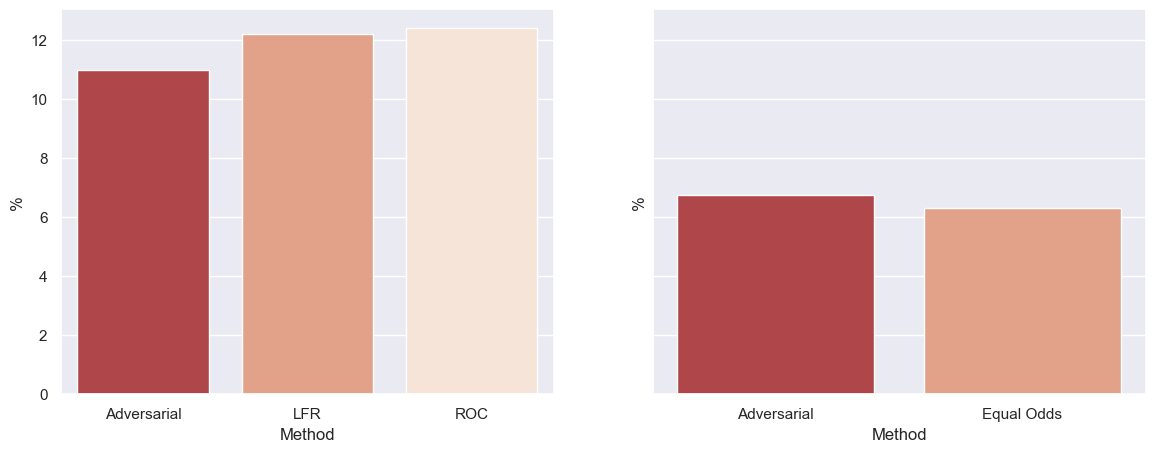

In [67]:
fig, axs = plt.subplots(1,2, figsize=(14,5), sharey=True)

sns.barplot(x=['Adversarial', 'LFR', 'ROC'],
            y=[len(adv_changed)/len(comp_df)*100,
              len(lfr_changed)/len(comp_df)*100,
               len(roc_changed)/len(comp_df)*100
              ],
            ax=axs[0]
           )

axs[0].set_xlabel('Method')
axs[0].set_ylabel('%')

sns.barplot(x=['Adversarial', 'Equal Odds'],
            y=[len(adveq_changed)/len(comp_df)*100,
              len(eq_changed)/len(comp_df)*100
              ],
            ax=axs[1]
           )

axs[1].set_xlabel('Method')
axs[1].set_ylabel('%')

#plt.savefig('../../figs/adult/perc_changed.png')
#plt.savefig('../../figs/adult/perc_changed.pdf')

In [68]:
nc = comp_df.assign(num_changes = lambda x: abs(x.adv_change) + abs(x.lfr_change) + abs(x.eq_change))[['num_changes']]

Text(0, 0.5, '%')

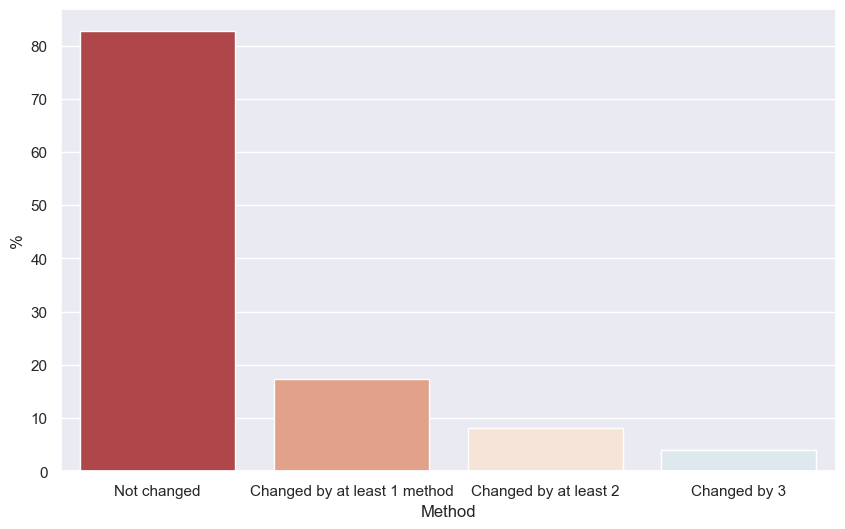

In [69]:
fig, axs = plt.subplots(1,1, figsize=(10,6))

sns.barplot(x=['Not changed', 'Changed by at least 1 method', 'Changed by at least 2', 'Changed by 3'],
            y=[len(nc[nc.num_changes==0])/len(nc)*100,
               len(nc[nc.num_changes>=1])/len(nc)*100,
               len(nc[nc.num_changes>=2])/len(nc)*100,
               len(nc[nc.num_changes>=3])/len(nc)*100
              ],
            ax=axs
           )

axs.set_xlabel('Method')
axs.set_ylabel('%')

In [70]:
print(len(nc[nc.num_changes!=0]))
print(len(nc[nc.num_changes>=1]))
print(len(nc[nc.num_changes>=2]))
print(len(nc[nc.num_changes>=3]))

2816
2816
1321
655


In [71]:
[len(nc[nc.num_changes==0])/len(nc[nc.num_changes!=0]),#*100,
               len(nc[nc.num_changes>=1])/len(nc[nc.num_changes!=0]),#*100,
               len(nc[nc.num_changes>=2])/len(nc[nc.num_changes!=0]),#*100,
               len(nc[nc.num_changes>=3])/len(nc[nc.num_changes!=0])#*100
              ]

[4.77734375, 1.0, 0.46910511363636365, 0.23259943181818182]

## People the methods focus on

In [72]:
roc_changed.groupby('sex').count()[['age']]

age
sex       
Male  2018

In [73]:
adv_perc_change_women = adv_changed.groupby('sex').count()[['age']].loc['Female'].age / len(adv_changed) * 100
adv_perc_change_men = adv_changed.groupby('sex').count()[['age']].loc['Male'].age / len(adv_changed) * 100

lfr_perc_change_women = lfr_changed.groupby('sex').count()[['age']].loc['Female'].age / len(lfr_changed) * 100
lfr_perc_change_men = lfr_changed.groupby('sex').count()[['age']].loc['Male'].age / len(lfr_changed) * 100

try:
    roc_perc_change_women = roc_changed.groupby('sex').count()[['age']].loc['Female'].age / len(roc_changed) * 100
except(KeyError):
    roc_perc_change_women = 0
    
roc_perc_change_men = roc_changed.groupby('sex').count()[['age']].loc['Male'].age / len(roc_changed) * 100

eq_perc_change_women = eq_changed.groupby('sex').count()[['age']].loc['Female'].age / len(eq_changed) * 100
eq_perc_change_men = eq_changed.groupby('sex').count()[['age']].loc['Male'].age / len(eq_changed) * 100

adveq_perc_change_women = adveq_changed.groupby('sex').count()[['age']].loc['Female'].age / len(adveq_changed) * 100
adveq_perc_change_men = adveq_changed.groupby('sex').count()[['age']].loc['Male'].age / len(adveq_changed) * 100

print('Demographic Parity:')
print(f'{adv_perc_change_women:.2f}% of the changes Adversarial made was to women ({adv_perc_change_men:.2f}% to men)')
print(f'{lfr_perc_change_women:.2f}% of the changes LFR made was to women ({lfr_perc_change_men:.2f}% to men)')
print(f'{roc_perc_change_women:.2f}% of the changes ROC made was to women ({roc_perc_change_men:.2f}% to men)')
print()

print('Equalized Odds:')
print(f'{eq_perc_change_women:.2f}% of the changes Equal Odds made was to women ({eq_perc_change_men:.2f}% to men)')
print(f'{adveq_perc_change_women:.2f}% of the changes Adversarial made was to women ({adveq_perc_change_men:.2f}% to men)')

Demographic Parity:
16.63% of the changes Adversarial made was to women (83.37% to men)
29.38% of the changes LFR made was to women (70.62% to men)
0.00% of the changes ROC made was to women (100.00% to men)

Equalized Odds:
37.17% of the changes Equal Odds made was to women (62.83% to men)
32.69% of the changes Adversarial made was to women (67.31% to men)


## Directions

In [74]:
counts = comp_df.groupby('sex').count()[['age']]

In [75]:
counts

age
sex          
Female   5403
Male    10866

In [76]:
comp_df.groupby(['sex', 'adv_change']).count()[['age']].rename({'age':'num'}, axis=1).reset_index()\
       .assign(perc = lambda y: y.apply(lambda x: x.num / counts.loc[x.sex].item() * 100, axis=1))

sex  adv_change   num       perc
0  Female        -1.0     4   0.074033
1  Female         0.0  5106  94.503054
2  Female         1.0   293   5.422913
3    Male        -1.0  1473  13.556046
4    Male         0.0  9377  86.296705
5    Male         1.0    16   0.147248

In [77]:
comp_df.groupby(['sex', 'lfr_change']).count()[['age']].rename({'age':'num'}, axis=1).reset_index()\
       .assign(perc = lambda y: y.apply(lambda x: x.num / counts.loc[x.sex].item() * 100, axis=1))

sex  lfr_change   num       perc
0  Female          -1    45   0.832871
1  Female           0  4821  89.228207
2  Female           1   537   9.938923
3    Male          -1  1268  11.669428
4    Male           0  9467  87.124977
5    Male           1   131   1.205595

In [78]:
comp_df.groupby(['sex', 'roc_change']).count()[['age']].rename({'age':'num'}, axis=1).reset_index()\
       .assign(perc = lambda y: y.apply(lambda x: x.num / counts.loc[x.sex].item() * 100, axis=1))

sex  roc_change   num        perc
0  Female         0.0  5403  100.000000
1    Male        -1.0  2018   18.571692
2    Male         0.0  8848   81.428308

In [79]:
comp_df.groupby(['sex', 'eq_change']).count()[['age']].rename({'age':'num'}, axis=1).reset_index()\
       .assign(perc = lambda y: y.apply(lambda x: x.num / counts.loc[x.sex].item() * 100, axis=1))

sex  eq_change    num       perc
0  Female         -1    121   2.239497
1  Female          0   5022  92.948362
2  Female          1    260   4.812141
3    Male         -1    644   5.926744
4    Male          0  10222  94.073256

In [80]:
comp_df.groupby(['sex', 'eq_change']).count()[['age']].rename({'age':'num'}, axis=1).reset_index()\
       .assign(perc = lambda y: y.apply(lambda x: x.num / counts.loc[x.sex].item() * 100, axis=1))

sex  eq_change    num       perc
0  Female         -1    121   2.239497
1  Female          0   5022  92.948362
2  Female          1    260   4.812141
3    Male         -1    644   5.926744
4    Male          0  10222  94.073256

In [81]:
comp_df[(comp_df.eq_change==-1) & (comp_df.sex=='Female')].groupby(['target', 'biased_pred']).count()

age  workclass  fnlwgt  education  education_num  \
target biased_pred                                                     
0      1             38         37      38         38             38   
1      1             83         77      83         83             83   

                    martial_status  occupation  relationship  race  sex  ...  \
target biased_pred                                                       ...   
0      1                        38          37            38    38   38  ...   
1      1                        83          77            83    83   83  ...   

                    adv_pred  lfr_pred  eq_pred  roc_pred  adveq_pred  \
target biased_pred                                                      
0      1                  38        38       38        38          38   
1      1                  83        83       83        83          83   

                    adv_change  lfr_change  roc_change  eq_change  \
target biased_pred                                                  
0      1                    38          38          38         38   
1      1                    83          83          83         83   

                    adveq_change  
target biased_pred                
0      1                      38  
1      1                      83  

[2 rows x 24 columns]

## Are they the same people ?

In [82]:
comp_df = comp_df.assign(nch = abs(comp_df.lfr_change) + abs(comp_df.eq_change) + abs(comp_df.adv_change))

In [83]:
changed_intersect = comp_df[comp_df.nch == 3]
changed_union = comp_df[comp_df.nch >= 1]

In [84]:
len(changed_union)

2816

### T-sne

In [85]:
tsne_df = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(X_test)

In [86]:
same_df = comp_df[comp_df.nch==3]

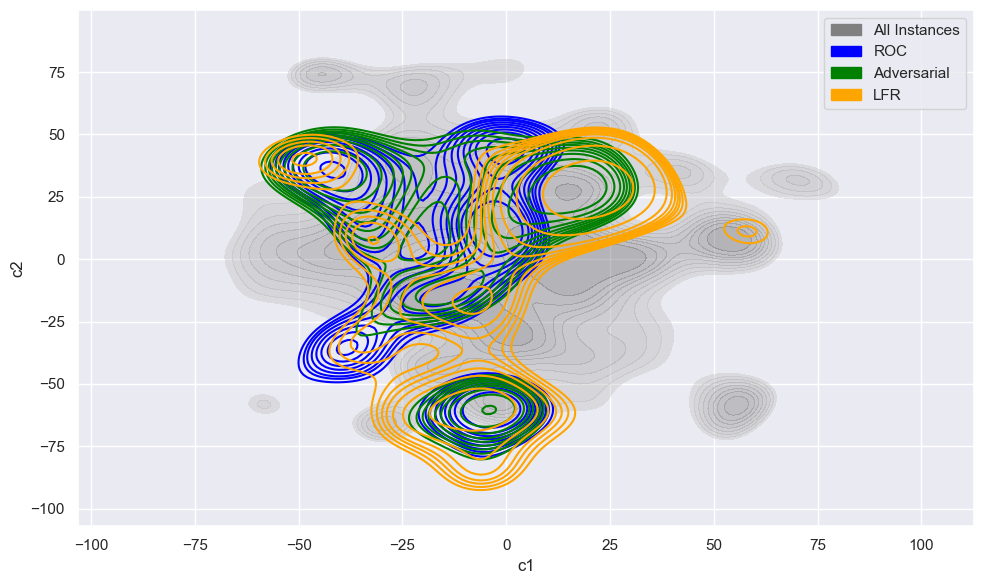

In [87]:
all_df = X_test.assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

plot_a = all_df.loc[adv_changed.index]
plot_l = all_df.loc[lfr_changed.index]
plot_r = all_df.loc[roc_changed.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,1, figsize=(10,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.5, alpha=0.4, legend=True, color='Grey', cut=0.5)

patch_all = mpatches.Patch(
    color='Grey', label='All Instances'
)

sns.kdeplot(data=plot_r, x='c1', y='c2', ax=axs, label='ROC', fill=False, thresh=0.6, color='Blue', cut=0.5)
patch_eq = mpatches.Patch(
    color='Blue', label='ROC'
)

sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.6, color='Green', cut=0.5)
patch_adv = mpatches.Patch(
    color='Green', label='Adversarial'
)

sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs, label='LFR', fill=False, thresh=0.6, color='Orange', cut=0.5)
patch_lfr = mpatches.Patch(
    color='Orange', label='LFR'
)

label_patches = [patch_all, patch_eq, patch_adv, patch_lfr]

#axs.set_xlim(-90, 100)
#axs.set_ylim(-75,100)

axs.legend(handles=label_patches)

#axs.set_title('T-SNE projection of Datapoints')

#plt.savefig('../../figs/adult/tsne_all.pdf')
#plt.savefig('../../figs/adult/tsne_all.png')
plt.tight_layout()

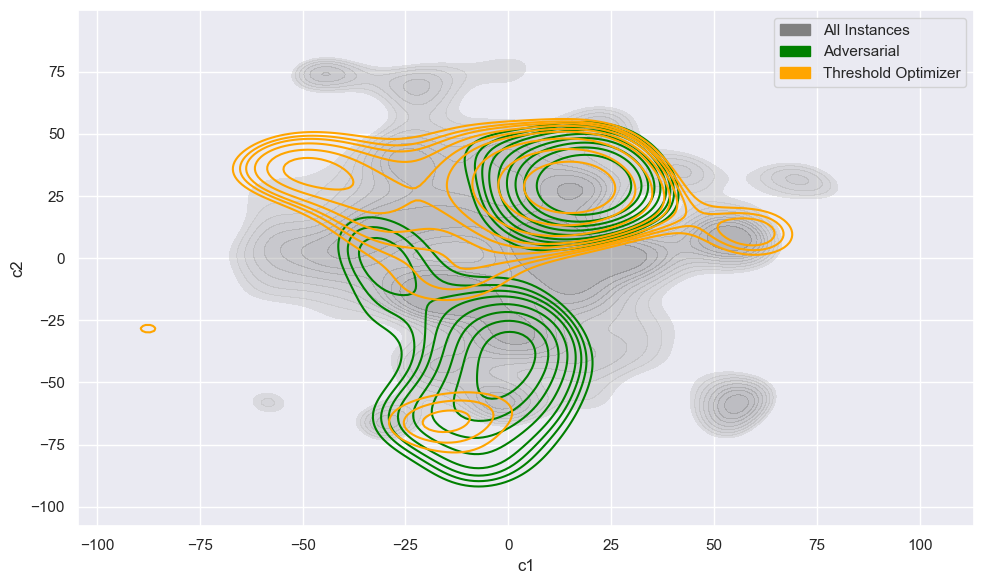

In [88]:
all_df = X_test.assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

plot_a = all_df.loc[adveq_changed.index]
plot_e = all_df.loc[eq_changed.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,1, figsize=(10,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.5, alpha=0.4, legend=True, color='Grey', cut=0.5)

patch_all = mpatches.Patch(
    color='Grey', label='All Instances'
)

sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.6, color='Green', cut=0.5)
patch_adv = mpatches.Patch(
    color='Green', label='Adversarial'
)

sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.6, color='Orange', cut=0.5)
patch_eq = mpatches.Patch(
    color='Orange', label='Threshold Optimizer'
)

label_patches = [patch_all, patch_adv, patch_eq]

#axs.set_xlim(-90, 100)
#axs.set_ylim(-75,100)

axs.legend(handles=label_patches)

#axs.set_title('T-SNE projection of Datapoints')

#plt.savefig('../../figs/adult/tsne_all.pdf')
#plt.savefig('../../figs/adult/tsne_all.png')
plt.tight_layout()

### UMAP

In [89]:
#import umap

# Values achieved

In [90]:
test_results.head()

sex  biased_label  adv_pred  lfr_pred  roc_pred  adveq_pred  eq_pred  \
24652    1           0.0       0.0         0       0.0           0        0   
26303    1           0.0       0.0         0       0.0           0        0   
21531    0           0.0       0.0         1       0.0           1        0   
294      0           0.0       0.0         0       0.0           0        0   
28849    0           0.0       0.0         1       0.0           0        0   

       target  biased_pred  
24652       0          0.0  
26303       0          0.0  
21531       0          0.0  
294         0          0.0  
28849       0          0.0

In [91]:
adv_perc_pos_men = len(test_results[(test_results.sex==1) & (test_results.adv_pred==1)]) / len(test_results[test_results.sex==1]) * 100
adv_perc_pos_women = len(test_results[(test_results.sex==0) & (test_results.adv_pred==1)]) / len(test_results[test_results.sex==0]) * 100

lfr_perc_pos_men = len(test_results[(test_results.sex==1) & (test_results.lfr_pred==1)]) / len(test_results[test_results.sex==1]) * 100
lfr_perc_pos_women = len(test_results[(test_results.sex==0) & (test_results.lfr_pred==1)]) / len(test_results[test_results.sex==0]) * 100

roc_perc_pos_men = len(test_results[(test_results.sex==1) & (test_results.roc_pred==1)]) / len(test_results[test_results.sex==1]) * 100
roc_perc_pos_women = len(test_results[(test_results.sex==0) & (test_results.roc_pred==1)]) / len(test_results[test_results.sex==0]) * 100

adveq_perc_pos_men = len(test_results[(test_results.sex==1) & (test_results.adveq_pred==1)]) / len(test_results[test_results.sex==1]) * 100
adveq_perc_pos_women = len(test_results[(test_results.sex==0) & (test_results.adveq_pred==1)]) / len(test_results[test_results.sex==0]) * 100

eq_perc_pos_men = len(test_results[(test_results.sex==1) & (test_results.eq_pred==1)]) / len(test_results[test_results.sex==1]) * 100
eq_perc_pos_women = len(test_results[(test_results.sex==0) & (test_results.eq_pred==1)]) / len(test_results[test_results.sex==0]) * 100

biased_perc_pos_men = len(test_results[(test_results.sex==1) & (test_results.biased_pred==1)]) / len(test_results[test_results.sex==1]) * 100
biased_perc_pos_women = len(test_results[(test_results.sex==0) & (test_results.biased_pred==1)]) / len(test_results[test_results.sex==0]) * 100

In [92]:
print('Demographic Parity:')
print(f'Adversarial: {adv_perc_pos_men:.2f}% of men, and {adv_perc_pos_women:.2f}% of women are classified positively')
print(f'LFR: {lfr_perc_pos_men:.2f}% of men, and {lfr_perc_pos_women:.2f}% of women are classified positively')
print(f'ROC: {roc_perc_pos_men:.2f}% of men, and {roc_perc_pos_women:.2f}% of women are classified positively')
print()
print('Equal Odds')
print(f'Adversarial: {adveq_perc_pos_men:.2f}% of men, and {adveq_perc_pos_women:.2f}% of women are classified positively')
print(f'Equal Odds: {eq_perc_pos_men:.2f}% of men, and {eq_perc_pos_women:.2f}% of women are classified positively')
print()
print(f'Equal Odds: {biased_perc_pos_men:.2f}% of men, and {biased_perc_pos_women:.2f}% of women are classified positively')

Demographic Parity:
Adversarial: 14.49% of men, and 14.12% of women are classified positively
LFR: 17.43% of men, and 17.88% of women are classified positively
ROC: 9.32% of men, and 8.77% of women are classified positively

Equal Odds
Adversarial: 23.52% of men, and 13.07% of women are classified positively
Equal Odds: 21.97% of men, and 11.35% of women are classified positively

Equal Odds: 27.89% of men, and 8.77% of women are classified positively
